In [ ]:
import joblib
import pickle
from transformers import AutoTokenizer, AutoConfig
import torch
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import seaborn as sns
from tqdm import tqdm

# Import SciBERT model and data

In [ ]:
## First load all texts to predict on and our hierarchically ordered labels
# all paras
filename = r"methods_paragraph_corpus.pickle"
with open(filename, "rb") as f:
    methods_paras = pickle.load(f)

# load list with categories of interest
filename = r"categories_of_interest.txt"
with open(filename, 'r') as file:
    cats = json.load(file)

# hierarchical classification of the categories
filename = r"classification_categories.txt"
with open(filename, "r") as file:
    classif = json.load(file)

# annotated data
df = pd.read_csv(r"testData13052025.csv")
df = df.drop(columns = 'Unnamed: 0')

# all paras in a df, without annotated
df_to_predict = pd.DataFrame([{key:methods_paras[key] for key in methods_paras.keys()}]).T # in case you want without the annotated ones, add "if key not in df.id.values"
df_to_predict.columns = ['text']

df_to_predict.head()

In [ ]:
# now load the model and supporting files

# Path to the directory containing the trained model and config files
MODEL_DIR = Path("final_model_scibert_scivocab_uncased")

# Load the model configuration (includes label mappings and other settings)
cfg = AutoConfig.from_pretrained(MODEL_DIR)

# Map from label IDs (integers) to label names (strings)
id2label = cfg.id2label

# Map from label names (strings) to label IDs (integers)
label2id = cfg.label2id

# Total number of labels in the classification task
num_labels = cfg.num_labels

# Load class frequencies from a JSON file
with open(MODEL_DIR / "class_frequencies.json") as f:
    class_freq = [freq for _, freq in sorted(json.load(f).items(), key=lambda kv: label2id[kv[0]])]

Include classes from model training. These are required to load the model and use it for prediction. 

In [ ]:
class DistributionBalancedLoss(nn.Module):
    """
    Distribution-Balanced (DB) loss from Wu & Huang (2020) and Huang et al. (2021)


    """
    def __init__(self,
                 class_freq,
                 rebalance_alpha=0.1, rebalance_beta=10.0, rebalance_mu=0.7,
                 focal_gamma=2.0,
                 negative_lambda=2.0, negative_kappa=0.05,
                 label_smoothing=0.0):                         



        super().__init__()

        # store class frequencies
        self.register_buffer("class_freq",
                             torch.tensor(class_freq, dtype=torch.float32))
        self.m = len(class_freq)

        # hyper-parameters
        self.alpha  = rebalance_alpha
        self.beta   = rebalance_beta
        self.mu     = rebalance_mu
        self.gamma  = focal_gamma
        self.lmbda  = negative_lambda
        self.kappa  = negative_kappa
        self.eps    = 1e-7
        self.label_smoothing = label_smoothing

        # negative-tolerant logit shift
        p_c = torch.clamp(self.class_freq / self.class_freq.sum(), 1e-7, 1-1e-7)
        # shift is -kappa * log(p_c / (1-p_c))
        self.register_buffer("v_i", -self.kappa * torch.log(p_c / (1 - p_c)))

    # ------------- helper functions -------------
    def _smooth(self, y):
        if self.label_smoothing <= 0:
            return y
        return y * (1 - self.label_smoothing) + 0.5 * self.label_smoothing

    def _rebalanced_weights(self, y):
        """
        Compute rebalanced weights for positives:
        - Inverse-frequency weighting
        - Normalized by number of classes
        - Then squashed through sigmoid(alpha + beta*(r_db - mu))
        """
                
        inv_n   = (1.0 / self.class_freq).unsqueeze(0)
        pos_m   = y > 0
        P_I     = (pos_m * inv_n / self.m).sum(1, keepdim=True) + self.eps
        P_C     = inv_n / self.m
        r_db    = P_C / P_I
        w       = self.alpha + torch.sigmoid(self.beta * (r_db - self.mu))
        # positives get rebalanced weight, negatives stay at 1
        return torch.where(pos_m, w, torch.ones_like(w))

    def forward(self, logits, y):
        """
        Compute DB loss for a batch.
        
        Args:
            logits: [batch, num_classes] raw model outputs
            y:      [batch, num_classes] binary ground-truth labels
        """
        y        = y.float()
        v_i      = self.v_i.to(logits.device)
        inv_l    = 1.0 / self.lmbda
        y_smooth = self._smooth(y)
        w        = self._rebalanced_weights(y).to(logits.device)

        # positives
        q_pos    = torch.sigmoid(logits - v_i)
        loss_pos = -w * ((1 - q_pos)**self.gamma) * (
                     y_smooth * torch.log(q_pos + self.eps) +
                     (1 - y_smooth) * torch.log(1 - q_pos + self.eps))

        # negatives
        q_neg    = torch.sigmoid(self.lmbda * (logits - v_i))
        loss_neg = -inv_l * (q_neg**self.gamma) * (
                     y_smooth * torch.log(q_neg + self.eps) +
                     (1 - y_smooth) * torch.log(1 - q_neg + self.eps))

        loss = torch.where(y > 0, loss_pos, loss_neg)
        return loss.mean()
    

class MultiLabelBERTClassification(nn.Module):
    """
    BERT-based model for multi-label classification.
    
    Architecture:
    - BERT encoder (frozen initially)
    - Linear classifier head
    - Custom loss function (DB loss)
    """
    def __init__(
        self,
        model_name: str,
        num_labels: int,
        class_frequencies,
        id2label: dict,
        label2id: dict,
        use_db_loss: bool = True,
        pos_weight=None  # For weighted BCE baseline if you use that loss function
    ):
        super().__init__()
        
        # Load pre-trained BERT model
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
            problem_type="multi_label_classification",
        )
        
        # Choose loss function
        if use_db_loss:
            print("Using Distribution Balanced Loss")
            self.loss_fn = DistributionBalancedLoss(
                class_freq=class_frequencies,
                label_smoothing=0.05,      # 5% label smoothing
                rebalance_alpha=0.1,       # Conservative rebalancing
                rebalance_beta=10,         # Moderate sharpness
                rebalance_mu=0.7,          # Slightly favor common classes
                focal_gamma=2.0,           # Standard focal loss
                negative_tolerant_lambda=2.0,
                negative_tolerant_kappa=0.05,
            )
        else:
            print("Using Binary Cross Entropy Loss")
            if pos_weight is not None:
                pos_weight = torch.tensor(pos_weight, dtype=torch.float32)
            self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    def forward(self, input_ids, attention_mask, labels=None, **extra):
        """
        Forward pass:
        - Run BERT on inputs
        - Compute custom loss if labels are provided
        """
        # Get BERT outputs
        logits = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,  # We calculate loss ourselves
            **extra
        ).logits
        
        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels.float())
        
        return {"loss": loss, "logits": logits}

# Make SciBERT predictions

In [59]:

# code for making predictions on new texts

@torch.no_grad() # disable gradient tracking (saves memory, speeds up inference)
def predict(texts, threshold=0.5, max_length=512, batch_size=32, device="cpu"):
    model.to(device)
    out = []
    for i in tqdm(range(0, len(texts), batch_size)):
        # Tokenize a batch of texts, truncate/pad to max_length, and send to device
        enc = tokenizer(texts[i:i+batch_size], padding=True, truncation=True,
                        max_length=max_length, return_tensors="pt").to(device)
        # Run model forward pass to get raw logits
        logits = model(**enc)["logits"]
        # Apply sigmoid to get probabilities per label, then move to numpy
        probs = torch.sigmoid(logits).cpu().numpy()
        out.append(probs)
    
    # Concatenate all batch results into one array [num_samples, num_labels]
    probs = np.vstack(out)

    labels = [id2label[i] for i in range(num_labels)]

    # Convert probabilities to predictions:
    preds = [[labels[j] for j, p in enumerate(row) if p >= threshold] for row in probs]

    # return labels and predictions as well as raw probabilities
    # we'll probably only need the probabilities, but this takes long so better be safe
    return preds, probs, labels

In [ ]:
# function to infer labels from other labels
# this includes broader levels in the hierarchy from leave nodes, but also related labels (such 'phylogenetic' from 'phylo_sd')
def propagate_hierarchy(pred_df, classif):
    """Return a copy where every parent/cross-link label is made 1
       if any of its children are 1."""
    out = pred_df.copy()

    # they could be bools, so convert to int first
    out = out.astype(int)

    def recurse(node):
        if isinstance(node, dict):
            for parent, children in node.items():
                recurse(children)
                child_keys = []
                for c in children:
                    if isinstance(c, str):
                        child_keys.append(c)
                    elif isinstance(c, dict):
                        child_keys.extend(c.keys())
                if child_keys:
                    out.loc[out[child_keys].eq(1).any(axis=1), parent] = 1
        elif isinstance(node, list):
            for item in node:
                recurse(item)

    recurse(classif)

    # cross-links outside the hierarchical classification
    if {'interbr_morph','gen_interbr','interbreeding'}.issubset(out):
        mask = (out.interbr_morph==1)|(out.gen_interbr==1)
        out.loc[mask, 'interbreeding'] = 1

    if {'distance_based','distance'}.issubset(out):
        out.loc[out.distance_based==1, 'distance'] = 1

    if {'phen_pylo','phylo_sd','phylo_tree','phylogenetic'}.issubset(out):
        mask = (out.phen_pylo==1)|(out.phylo_sd==1)|(out.phylo_tree==1)
        out.loc[mask, 'phylogenetic'] = 1
    
    

    return out


# function to flatten the hierarchical classification
# this just for using groupings of labels
def flatten(node):
    """Return a list of all string keys/leaves in the (nested) node."""
    if isinstance(node, str):
        return [node]
    elif isinstance(node, dict):
        out = []
        for k, v in node.items():
            out.append(k)
            out.extend(flatten(v))
        return out
    elif isinstance(node, list):
        out = []
        for item in node:
            out.extend(flatten(item))
        return out
    else:
        return []

# extract label lists for three top‑level branches
# we will use these for plotting
phen_labels = flatten(classif['phenotype'])
geno_labels = flatten(classif['genotype'])
single_labels = classif['singletons']  # already a flat list

In [ ]:
# instantiate and load weights
model = MultiLabelBERTClassification(
    model_name=str(MODEL_DIR),     
    num_labels=num_labels,
    class_frequencies=class_freq,
    id2label=id2label,
    label2id=label2id,
    use_db_loss=True
)

sd = torch.load(MODEL_DIR / "pytorch_model.bin", map_location="cpu")
model.load_state_dict(sd, strict=True)   
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at final_model_scibert_scivocab_uncased and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder

Using Distribution Balanced Loss


Prediction on all methods paragraphs(n= 44853, for a total of 28312 papers) took 6h13 on our intel core i7 (no GPU). 

In [ ]:
# texts that we want to assign labels to
new_texts = df_to_predict['text'].values
# preds, probs, labels = predict(list(new_texts))

# save the raw probabilities for later use
pd.DataFrame(probs, columns=labels).to_csv("all_predictions_sccibert_probabilities.csv", index=False)

# # Put the predictions into a DataFrame with proper column (label) names
df_new_hat  = pd.DataFrame(probs > 0.5, columns=cats)

# # Enforce hierarchical consistency between labels, then fill missing values with 0 and convert to int
df_new_hat  = propagate_hierarchy(df_new_hat, classif).fillna(0).astype(int)

# # add indices, paper and texts to the resulting df
df_new_hat['text'] = new_texts
df_new_hat.index = df_to_predict.index
df_new_hat['paper'] = [i.split('.json')[0] for i in df_new_hat.index]

df_new_hat.head()

,phenotype,phen_data,morph,biogeo,color_pattern,phen_proc,imaging,quant_morph,storage,sampling,...,phen_pylo,distance_based,acoustic,phylo_sd,interbreeding,specimen_storage_loc,abbrev_terms,singletons,text,paper
./Corpus/Zootaxa/7/zootaxa_7_1_1.json_0,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,Pupal exuviae were collected with a Brundin ne...,./Corpus/Zootaxa/7/zootaxa_7_1_1
./Corpus/Zootaxa/7/zootaxa_7_1_1.json_1,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,Specimens were mounted on slides in Canada Bal...,./Corpus/Zootaxa/7/zootaxa_7_1_1
./Corpus/Zootaxa/9/zootaxa_9_1_1.json_0,1,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,During July and August 2000 grass samples were...,./Corpus/Zootaxa/9/zootaxa_9_1_1
./Corpus/Zootaxa/9/zootaxa_9_1_1.json_1,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,Measurements of mites were made according to A...,./Corpus/Zootaxa/9/zootaxa_9_1_1
./Corpus/Zootaxa/1/zootaxa_10_1_1.json_0,1,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,Table 1 reports\ngeneral information on the po...,./Corpus/Zootaxa/1/zootaxa_10_1_1


# Make a paper level df

In [ ]:
# the predictions are per paragraph, but we want them per paper
# so we group by paper and take the max (1 or 0) per category
df_new_hat_paper = (
    df_new_hat
    .groupby('paper')[cats]
    .max()
    .reset_index()
)

print(df_new_hat_paper.shape)
df_new_hat_paper.head()

(28312, 39)


,paper,phenotype,phen_data,morph,biogeo,color_pattern,phen_proc,imaging,quant_morph,storage,...,behav,phylogenetic,rank_just,phen_pylo,distance_based,acoustic,phylo_sd,interbreeding,specimen_storage_loc,abbrev_terms
0,./Corpus/EJT/10_5852_ejt_2011_2,1,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
1,./Corpus/EJT/10_5852_ejt_2011_3,1,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,./Corpus/EJT/10_5852_ejt_2012_11,1,1,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,1,1,1
3,./Corpus/EJT/10_5852_ejt_2012_12,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,./Corpus/EJT/10_5852_ejt_2012_13,1,1,1,1,1,1,1,1,0,...,0,0,1,0,0,0,0,1,1,0


In [ ]:
# save the predictions per paper for uploading them
filepath = r'C:\Users\conix\Dropbox\FNRS project taxonomy\methods in taxonomy\data\methods_full_corpus_prediction_scibert.csv'
df_new_hat_paper.to_csv(filepath, sep = ';', index=False)

# look at the data

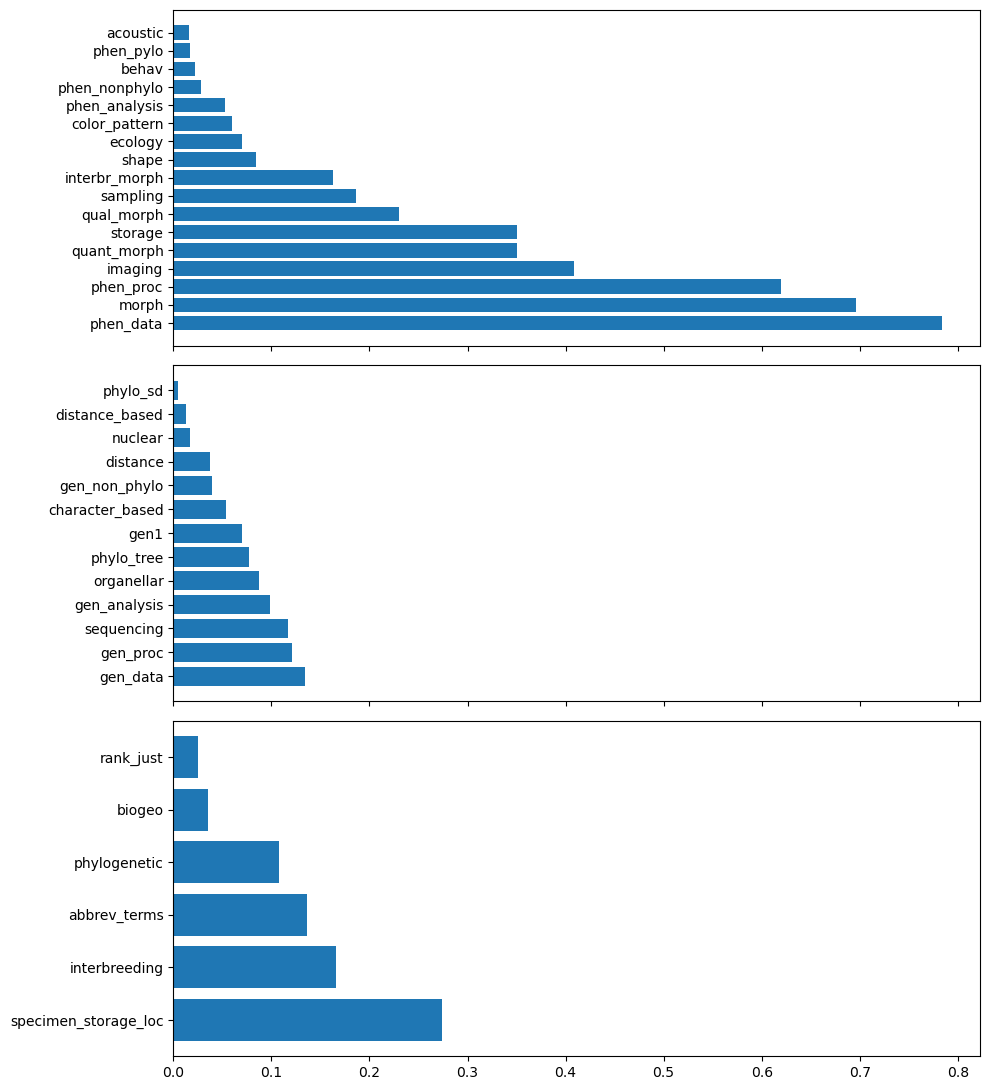

In [55]:
fig, axs = plt.subplots(nrows = 3, figsize = (10, 11), sharex=True)

for group, ax in zip([phen_labels, geno_labels, single_labels], axs.flat):
    freqs = pd.Series(df_new_hat[group].sum() / len(df_new_hat)).sort_values(ascending = False)
    ax.barh(y= freqs.index, width=freqs.values)


fig.tight_layout()

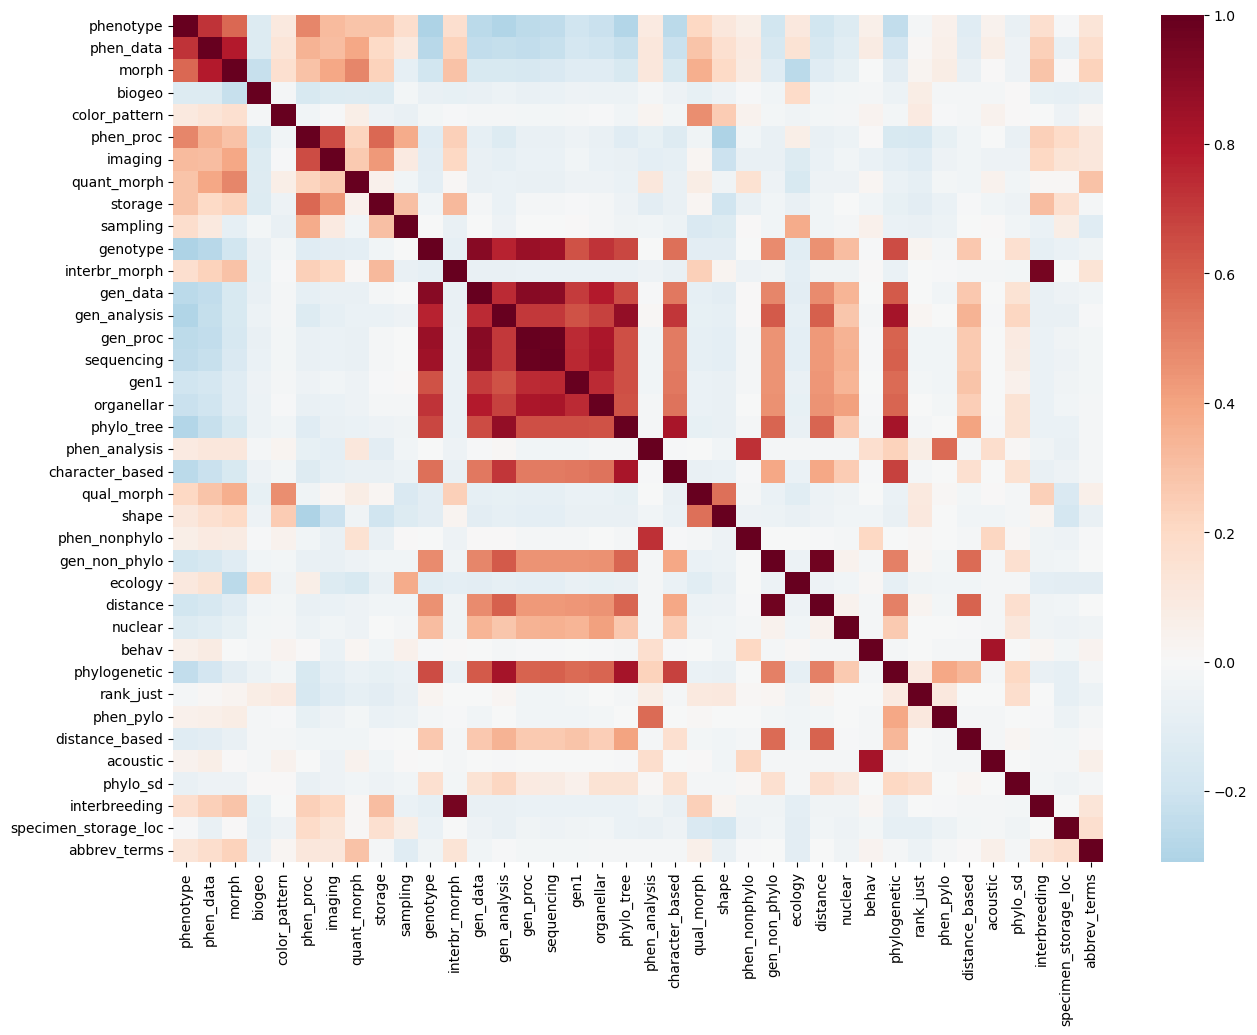

In [58]:

corr = df_new_hat[cats].corr()                         
plt.figure(figsize=(15,11))             
sns.heatmap(corr, annot=False, cmap="RdBu_r", center=0)
plt.show()